In [43]:
import numpy as np
import netCDF4 as nc
import auxiliary as au
import regression as reg
import datetime as dt
from matplotlib import pyplot as plt
from scipy import io
from scipy.interpolate import interp2d
import os
import sys
from scipy.interpolate import griddata
import h5py
import time
import random
import datetime


def divide_train_test(data, dividenum, randseed=-1):
    if randseed == -1:
        random.seed(time.time())
    num = len(data)
    subnum = int(num / dividenum)
    data_train = np.zeros([dividenum, num - subnum], dtype=int)
    data_test = np.zeros([dividenum, subnum], dtype=int)
    randindex = random.sample(range(num), num)
    for i in range(dividenum):
        data_test[i, :] = np.sort(data[randindex[i * subnum:(i + 1) * subnum]])
        data_train[i, :] = np.setdiff1d(data, data_test[i])
    return data_train, data_test


def double_cvindex(gmet_stndatafile, dividenum, rndseed=123):
    # index for double cross-validation
    datatemp = np.load(gmet_stndatafile)
    prcp_stn0 = datatemp['prcp_stn'][:, 0]
    tmean_stn0 = datatemp['tmean_stn'][:, 0]
    prcp_stnindex = np.argwhere(~np.isnan(prcp_stn0))
    prcp_stnindex = prcp_stnindex.flatten()
    tmean_stnindex = np.argwhere(~np.isnan(tmean_stn0))
    tmean_stnindex = tmean_stnindex.flatten()

    subnum1 = int(len(prcp_stnindex) / dividenum)
    subnum2 = int((len(prcp_stnindex) - subnum1) / dividenum)
    # prcp_testindex1 = np.zeros([dividenum,subnum1])
    # prcp_trainindex1 = np.zeros([dividenum,len(prcp_stnindex) - subnum1])
    prcp_trainindex1, prcp_testindex1 = divide_train_test(prcp_stnindex, dividenum, randseed=rndseed)
    prcp_testindex2 = np.zeros([dividenum, dividenum, subnum2], dtype=int)
    prcp_trainindex2 = np.zeros([dividenum, dividenum, len(prcp_stnindex) - subnum1 - subnum2], dtype=int)
    for i in range(dividenum):
        traini, testi = divide_train_test(prcp_trainindex1[i, :], dividenum, randseed=rndseed)
        prcp_trainindex2[i, :, :] = traini
        prcp_testindex2[i, :, :] = testi

    subnum1 = int(len(tmean_stnindex) / dividenum)
    subnum2 = int((len(tmean_stnindex) - subnum1) / dividenum)
    # tmean_testindex1 = np.zeros([dividenum,subnum1])
    # tmean_trainindex1 = np.zeros([dividenum,len(tmean_stnindex) - subnum1])
    tmean_trainindex1, tmean_testindex1 = divide_train_test(tmean_stnindex, dividenum, randseed=rndseed)
    tmean_testindex2 = np.zeros([dividenum, dividenum, subnum2], dtype=int)
    tmean_trainindex2 = np.zeros([dividenum, dividenum, len(tmean_stnindex) - subnum1 - subnum2], dtype=int)
    for i in range(dividenum):
        traini, testi = divide_train_test(tmean_trainindex1[i, :], dividenum, randseed=rndseed)
        tmean_trainindex2[i, :, :] = traini
        tmean_testindex2[i, :, :] = testi
    return prcp_trainindex1, prcp_testindex1, prcp_trainindex2, prcp_testindex2, \
           tmean_trainindex1, tmean_testindex1, tmean_trainindex2, tmean_testindex2


def calculate_anomaly(datatar, dataref, hwsize, amode, upbound=5, lowbound=0.2):
    # datatar, dataref: 2D [nstn, ntime]
    # amode: anomaly mode ('ratio' or 'diff')
    # hwsize: define time window (2*hwsize+1) used to calculate ratio (as ratio for a specific day is too variable)
    # upbound/lowbound: upper and lower limitation of ratio/difference
    if np.ndim(datatar) == 1:  # only one time step
        datatar = datatar[:, np.newaxis]
        dataref = dataref[:, np.newaxis]

    nstn, ntime = np.shape(datatar)
    if ntime < hwsize * 2 + 1:
        print('The window size is larger than time steps when calculating ratio between tar and ref datasets')
        print('Please set a smaller hwsize')
        sys.exit()

    indnan = np.isnan(datatar) | np.isnan(dataref)
    datatar[indnan] = np.nan
    dataref[indnan] = np.nan
    del indnan

    anom = np.ones([nstn, ntime])

    for i in range(ntime):
        if i < hwsize:
            windex = np.arange(hwsize * 2 + 1)
        elif i >= ntime - hwsize:
            windex = np.arange(ntime - hwsize * 2 - 1, ntime)
        else:
            windex = np.arange(i - hwsize, i + hwsize + 1)
        dtari = np.nanmean(datatar[:, windex], axis=1)
        drefi = np.nanmean(dataref[:, windex], axis=1)

        if amode == 'ratio':
            temp = drefi / dtari
            temp[(dtari == 0) & (drefi == 0)] = 1
            anom[:, i] = temp
        elif amode == 'diff':
            anom[:, i] = drefi - dtari
        else:
            sys.exit('Unknow amode. Please use either ratio or diff')

    anom[anom > upbound] = upbound
    anom[anom < lowbound] = lowbound
    return anom


def extrapolation(latin, lonin, datain, latout, lonout, nearnum):
    # datain: one or multiple time steps
    wexp = 3
    if np.ndim(datain) == 1:  # add time axis
        datain = datain[:, np.newaxis]
    latin[np.isnan(datain[:, 0])] = np.nan
    lonin[np.isnan(datain[:, 0])] = np.nan

    if np.ndim(latout) == 1:  # extrapolate to station points
        nearstn_loc, nearstn_dist = findnearstn(latin, lonin, latout, lonout, nearnum, 1)
        num = len(latout)
        ntimes = np.shape(datain)[1]
        dataout = np.zeros([num, ntimes])
        for i in range(num):
            dataini = datain[nearstn_loc[i, :], :]
            disti = nearstn_dist[i, :]
            weighti = au.distanceweight(disti, np.max(disti) + 1, wexp)
            weighti = weighti / np.sum(weighti)
            for j in range(ntimes):
                dataout[i, j] = np.sum(dataini[:, j] * weighti)

    elif np.ndim(latout) == 2:  # extrapolate to gridds
        nearstn_loc, nearstn_dist = findnearstn(latin, lonin, latout, lonout, nearnum, 0)
        nrows, ncols, ntimes = np.shape(datain)
        dataout = np.zeros([nrows, ncols, ntimes])
        for r in range(nrows):
            for c in range(ncols):
                dataini = datain[nearstn_loc[r, c, :], :]
                disti = nearstn_dist[r, c, :]
                weighti = au.distanceweight(disti, np.max(disti) + 1, wexp)
                weighti = weighti / np.sum(weighti)
                for j in range(ntimes):
                    dataout[r, c, j] = np.sum(dataini[:, j] * weighti)
    else:
        print('The dimensions of tarlat or tarlon are larger than 2')
        sys.exit()

    return dataout


def findnearstn(stnlat, stnlon, tarlat, tarlon, nearnum, noself):
    # only use lat/lon to find near stations without considering distance in km
    # stnlat/stnlon: 1D
    # tarlat/tarlon: 1D or 2D
    # noself: 1--stnlat and tarlat have overlapped stations, which should be excluded from stnlat

    stnll = np.zeros([len(stnlat), 2])
    stnll[:, 0] = stnlat
    stnll[:, 1] = stnlon

    if len(np.shape(tarlat)) == 1:
        num = len(tarlat)
        nearstn_loc = np.zeros([num, nearnum], dtype=int)
        nearstn_dist = np.zeros([num, nearnum], dtype=float)
        for i in range(num):
            tari = np.array([tarlat[i], tarlon[i]])
            dist = au.distance(tari, stnll)
            dist[np.isnan(dist)] = 1000000000
            if noself == 1:
                dist[dist == 0] = np.inf  # may not be perfect, but work for SCDNA
            indi = np.argsort(dist)
            nearstn_loc[i, :] = indi[0:nearnum]
            nearstn_dist[i, :] = dist[nearstn_loc[i, :]]
    elif len(np.shape(tarlat)) == 2:
        nrows, ncols = np.shape(tarlat)
        nearstn_loc = np.zeros([nrows, ncols, nearnum], dtype=int)
        nearstn_dist = np.zeros([nrows, ncols, nearnum], dtype=float)
        for r in range(nrows):
            for c in range(ncols):
                tari = np.array([tarlat[r, c], tarlon[r, c]])
                dist = au.distance(tari, stnll)
                dist[np.isnan(dist)] = 1000000000
                indi = np.argsort(dist)
                nearstn_loc[r, c, :] = indi[0:nearnum]
                nearstn_dist[r, c, :] = dist[nearstn_loc[r, c, :]]
    else:
        print('The dimensions of tarlat or tarlon are larger than 2')
        sys.exit()

    return nearstn_loc, nearstn_dist


def error_correction(dataori, anomaly, mode='ratio'):
    # default: time is the last dimension
    if mode == 'ratio':
        datacorr = dataori * anomaly
    elif mode == 'diff':
        datacorr = dataori + anomaly
    else:
        sys.exit('Wrong error correction mode')
    return datacorr


def calweight(obsall, preall, mode='RMSE', preprocess=True):
    nstn, ntime = np.shape(obsall)
    met = np.nan * np.zeros(nstn)
    for i in range(nstn):
        obs = obsall[i, :]
        pre = preall[i, :]
        if preprocess:
            # delete the nan values
            ind_nan = np.isnan(obs) | np.isnan(pre)
            obs = obs[~ind_nan]
            pre = pre[~ind_nan]

        if len(obs) < 3:
            continue

        if mode == 'RMSE':
            met[i] = np.sqrt(np.sum(np.square(obs - pre)) / len(obs))  # RMSE
        elif mode == 'CC':
            temp = np.corrcoef(obs, pre)
            met[i] = temp[0][1]  # CC
        else:
            sys.exit('Unknown inputs for calmetric')

    if mode == 'RMSE':
        weight = 1 / (met ** 2)
    elif mode == 'CC':
        met[met < 0] = 0
        weight = met ** 2
    else:
        sys.exit('Unknown inputs for calmetric')

    return weight


def calmetric(dtar, dref, metname='RMSE'):
    if np.ndim(dtar) == 1:
        dtar = dtar[np.newaxis, :]
        dref = dref[np.newaxis, :]
    nstn, ntimes = np.shape(dtar)
    metout = np.nan * np.zeros(nstn, dtype=np.float32)
    if metname == 'RMSE':
        for i in range(nstn):
            metout[i] = np.sqrt(np.nansum(np.square(dtar[i, :] - dref[i, :])) / ntimes)  # RMSE
    elif metname == 'CC':
        for i in range(nstn):
            temp = np.corrcoef(dtar[i, :], dref[i, :])
            metout[i] = temp[0, 1]
    else:
        sys.exit('Unkown metric name')
    return metout


def ismember(a, b):
    # tf = np.in1d(a,b) # for newer versions of numpy
    tf = np.array([i in b for i in a])
    u = np.unique(a[tf])
    index = np.array([(np.where(b == i))[0][-1] if t else 0 for i, t in zip(a, tf)])
    return tf, index


def weightmerge(data, weight):
    if np.ndim(data) == 2:
        num, nmodel = np.shape(data)
        dataout = np.zeros(num)
        for i in range(num):
            dataout[i] = np.sum(data[i, :] * weight[i, :]) / np.sum(weight[i, :])
    elif np.ndim(data) == 3:
        nrows, ncols, nmodel = np.shape(data)
        for i in range(nmodel):
            data[:, :, i] = data[:, :, i] * weight[:, :, i]
        dataout = np.nansum(data, axis=2) / np.nansum(weight, axis=2)
    return dataout


def m_DateList(year_start, year_end, mode):
    # generate a date list (yyyymmdd) between start year and end year
    # mode: 'ByDay', 'ByMonth', 'ByYear': time scales of input files
    date_start = datetime.date(year_start, 1, 1)
    date_end = datetime.date(year_end, 12, 31)
    daynum = (date_end - date_start).days + 1

    # generate date in format: yyyymmdd
    date_ymd = np.zeros(daynum, dtype=int)
    dated = date_start
    for d in range(daynum):
        if d > 0:
            dated = dated + datetime.timedelta(days=1)
        date_ymd[d] = int(dated.strftime("%Y%m%d"))
    date_number = {'yyyymmdd': date_ymd,
                   'yyyymm': np.floor(date_ymd / 100).astype(int),
                   'yyyy': np.floor(date_ymd / 10000).astype(int),
                   'mm': np.floor(np.mod(date_ymd, 10000) / 100).astype(int),
                   'dd': np.mod(date_ymd, 100).astype(int)}

    # generate file list
    if mode == 'ByDay':
        datemode = date_number['yyyymmdd']
    else:
        if mode == 'ByMonth':
            datemode = date_number['yyyymm']
        elif mode == 'ByYear':
            datemode = date_number['yyyy']
        datemode = np.unique(datemode)

    date_list = [' '] * len(datemode)
    for i in range(len(datemode)):
        date_list[i] = str(datemode[i])

    return date_list, date_number


########################################################################################################################

# basic settings
lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)
var = 'prcp'  # ['prcp', 'tmean', 'trange']: this should be input from sbtach script
corrmode = 'ratio'  # ratio or diff: mode for error correction
hwsize = 0  # define time window (2*hwsize+1) used to calculate ratio (as ratio for a specific day is too variable)
nearnum = 8  # the number of nearby stations used to extrapolate points to grids (for correction and merging)
weightmode = 'RMSE'  # the metric used to guide merging (CC or RMSE). Weight = CC**2 or 1/RMSE**2
dividenum = 10  # divide the datasets into X parts, e.g. 10-fold cross-validation
anombound = [0.2,
             5]  # upper and lower bound when calculating the anomaly between target and reference data for correction

if corrmode == 'diff':
    # default settings in this study since diff is for tmean and trange
    hwsize = 0
    anombound = [-999, 999]

# input files
# station list and data
# gmet_stnfile = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/stnlist_whole.txt'
# gmet_stndatafile = '/home/gut428/stndata_whole.npz'
gmet_stnfile = '/Users/localuser/GMET/pyGMET_NA/stnlist_whole.txt'
gmet_stndatafile = '/Users/localuser/GMET/pyGMET_NA/stndata_whole.npz'  # to be saved. only process when absent

# mask file
# file_mask = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'
file_mask = './DEM/NA_DEM_010deg_trim.mat'

# downscaled reanalysis: gridded data
path_readown = ['', '', '']
prefix = ['ERA5_', 'MERAA2_', 'JRA55_']
# downscaled reanalysis data at station points
file_readownstn = ['/Users/localuser/Research/Test/ERA5_downto_stn.npz',
                   '/Users/localuser/Research/Test/MERRA2_downto_stn.npz',
                   '/Users/localuser/Research/Test/JRA55_downto_stn.npz']

# output files
# train and test index file
ttindexfile = '/Users/localuser/Research/Test/2layer_train_test_index.npz'

# error and merging at station level
path_reastn_cv = '/Users/localuser/Research/Test'
file_corrmerge_stn = path_reastn_cv + 'merge_corr_' + var + '_stn.npz'

# output corrected and merged data
path_cv_corrstn = ''  # the path where the corrected reanalysis data at each station points is stored
path_reacorr = ''
path_merge = ''
file_error_corr = ['', '',
                   '']  # the error at all station points for corrected reanalysis data (based on cross-validation)

########################################################################################################################

# basic processing
# mask
mask = io.loadmat(file_mask)
mask = mask['DEM']
mask[~np.isnan(mask)] = 1  # 1: valid pixels
# attributes
reanum = len(file_readownstn)
nrows, ncols = np.shape(mask)
lontarm, lattarm = np.meshgrid(lontar, lattar)

# date
date_list, date_number = m_DateList(1979, 2018, 'ByYear')

########################################################################################################################

# design a two-layer cross-validation: generate station combinations
# index1 extracts 90% stations for merging and 10% stations for validation
# index2 divides the 90% from index1 into 90% and 10% again for error correction
if not os.path.isfile(ttindexfile):
    prcp_trainindex1, prcp_testindex1, prcp_trainindex2, prcp_testindex2, \
    tmean_trainindex1, tmean_testindex1, tmean_trainindex2, tmean_testindex2 = \
        double_cvindex(gmet_stndatafile, dividenum, rndseed=123)
    np.savez_compressed(ttindexfile, prcp_trainindex1=prcp_trainindex1, prcp_testindex1=prcp_testindex1,
                        prcp_trainindex2=prcp_trainindex2, prcp_testindex2=prcp_testindex2,
                        tmean_trainindex1=tmean_trainindex1, tmean_testindex1=tmean_testindex1,
                        tmean_trainindex2=tmean_trainindex2, tmean_testindex2=tmean_testindex2)
    del prcp_trainindex1, prcp_testindex1, prcp_trainindex2, prcp_testindex2, \
        tmean_trainindex1, tmean_testindex1, tmean_trainindex2, tmean_testindex2

taintestindex = np.load(ttindexfile)

########################################################################################################################

# estimate the error of corrected and merged data at station points using cross-validation
# target outputs: weights for merging, merge choice, error of the merged dataset
# 0. load regression estimates and observations for all stations
# 1. select layer-1 stations (90% train, 10% test)
# 2. select layer-2 stations: 10 combinations (90% train, 10% test) from the 90% stations in layer-1
# 3. for all combinations in layer-2
# 3.1 perform error correction (1) at station points, (2) extrapolate to grids using training stations
# 3.2 perform evaluation using test stations
# 3.3 loop for all combinations and do evaluation at all stations (the 90% training stations from layer-1)
# 3.4 extrapolate evaluation accuracy indicators to the domain
# 4. merge three reanalysis using their indicators in 3.4
# 5. repeat 1-4 for all combinations in layer-1, and get accuracy indicators of the merged dataset for the domain
# 6. use indicators from 3.4 and 5, and select the best one among three reanalysis and merged datasets for each grid
# 7. get the final merged dataset and its accuracy indicators from steo-6

# load observations for all stations
datatemp = np.load(gmet_stndatafile)
stndata = datatemp[var + '_stn']
stnlle = datatemp['stn_lle']
nstn, ntimes = np.shape(stndata)
del datatemp

# load downscaled reanalysis for all stations
readata_stn = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)
for rr in range(reanum):
    dr = np.load(file_readownstn[rr])
    temp = dr[var + '_readown']
    if prefix[rr] == 'MERRA2_':  # unify the time length of all data as MERRA2 lacks 1979
        add = np.nan * np.zeros([nstn, 365])
        temp = np.stack((add, temp), axis=1)
    readata_stn[rr, :, :] = temp
    del dr, temp

# get merged and corrected reanalysis data at all station points using two-layer cross-validation
# layer-1: aim to obtain correction and merged data at station points through cross-validation
# layer-2: aim to obtain independent evaluation of correction data to support calculating merging weight in layer-1
if not os.path.isfile(file_corrmerge_stn):
    # initialization
    reacorr_stn = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)  # corrected reanalysis data
    reamerge_weight_stn = np.nan * np.zeros([nstn, reanum])  # weight used to obtain reamerge_stn
    reamerge_stn = np.nan * np.zeros([nstn, ntimes], dtype=np.float32) # merged reanalysis at station points

    for lay1 in range(5,6):
        print('Correction/Merging at station points. Layer-1:',lay1)
        # extract train and test index for layer-1
        if var == 'trange':
            vari = 'tmean'  # trange and tmean have the same index
        else:
            vari = var
        trainindex1 = taintestindex[vari + '_trainindex1'][lay1, :]
        testindex1 = taintestindex[vari + '_testindex1'][lay1, :]
        stndata_trainl1 = stndata[trainindex1, :]
        stndata_testl1 = stndata[testindex1, :]
        stnlle_trainl1 = stnlle[trainindex1, :]
        stnlle_testl1 = stnlle[testindex1, :]

        # filename: save inputs for each layer-1
        file_reacorrl1 = path_reastn_cv + 'reacorr_' + var + '_layer1_' + str(lay1 + 1) + '.npz'
        if os.path.isfile(file_reacorrl1):
            datatemp = np.load(file_reacorrl1)
            reacorr_trainl1 = datatemp['reacorr']
            weight_trainl1 = datatemp['reaweight']
            del datatemp
        else:

            # layer-2: start
            reacorr_trainl1 = np.zeros([reanum, len(trainindex1), ntimes], dtype=np.float32)
            weight_trainl1 = np.zeros([len(trainindex1), reanum], dtype=np.float32)

            for lay2 in range(5,6):
                print('Correction/Merging at station points. Layer-2:',lay2)
                # extract train and test index for layer-2 (subsets of trainindex1)
                trainindex2 = taintestindex[vari + '_trainindex2'][lay1, lay2, :]
                testindex2 = taintestindex[vari + '_testindex2'][lay1, lay2, :]
                stndata_trainl2 = stndata[trainindex2, :]
                stndata_testl2 = stndata[testindex2, :]
                stnlle_trainl2 = stnlle[trainindex2, :]
                stnlle_testl2 = stnlle[testindex2, :]

                for rr in range(reanum):
                    readata_trainl2 = readata_stn[rr, trainindex2, :]
                    readata_testl2 = readata_stn[rr, testindex2, :]

                    ### calculate corrected reanalysis data
                    # calculate anomaly at the train stations
                    anom_ori = calculate_anomaly(readata_trainl2, stndata_trainl2, hwsize, corrmode,
                                                 upbound=anombound[1], lowbound=[0])
                    # extrapolate the ratio to the test stations
                    anom_ext = extrapolation(stnlle_trainl2[:, 0], stnlle_trainl2[:, 1], anom_ori,
                                             stnlle_testl2[:, 0], stnlle_testl2[:, 1], nearnum)
                    # correct data at the test stations
                    readata_testl2_corr = error_correction(readata_testl2, anom_ext, mode=corrmode)
                    tf, index = ismember(testindex2, trainindex1)
                    reacorr_trainl1[rr, index, :] = readata_testl2_corr

            for rr in range(reanum):
                weight_trainl1[:, rr] = calweight(stndata_trainl1, reacorr_trainl1[rr,:,:], weightmode)

            np.savez_compressed(file_reacorrl1, reacorr=reacorr_trainl1, stnlle=stnlle_trainl1,
                                reaweight=weight_trainl1)
            # layer-2: end

        # extrapolate the weight from train stations to test stations (in layer-1)
        weight_testl1 = extrapolation(stnlle_trainl1[:, 0], stnlle_trainl1[:, 1], weight_trainl1,
                                      stnlle_testl1[:, 0], stnlle_testl1[:, 1], nearnum)
        reamerge_weight_stn[testindex1, :] = weight_testl1

        # merge reanalysis products at the test stations
        nstn_testl1 = len(testindex1)
        mergedata_testl1 = np.nan * np.zeros([nstn_testl1, ntimes])
        for i in range(ntimes):
            datain = np.zeros([nstn_testl1, reanum], dtype=np.float32)
            for rr in range(reanum):
                datain[:, rr] = readata_stn[rr, testindex1, i]
            dataout = weightmerge(datain, weight_testl1)
            mergedata_testl1[:, i] = dataout
        reamerge_stn[testindex1, :] = mergedata_testl1

        # repeat error correction using train stations in layer-1 (as in layer-2 only 0.9*0.9=0.81 stations are used)
        # extrapolate from train stations to test stations
        for rr in range(reanum):
            readata_trainl1 = readata_stn[rr, trainindex1, :]
            readata_testl1 = readata_stn[rr, testindex1, :]
            anom_ori = calculate_anomaly(readata_trainl1, stndata_trainl1, hwsize, corrmode,
                                         upbound=anombound[1], lowbound=[0])
            anom_ext = extrapolation(stnlle_trainl1[:, 0], stnlle_trainl1[:, 1], anom_ori,
                                     stnlle_testl1[:, 0], stnlle_testl1[:, 1], nearnum)
            readata_testl1_corr = error_correction(readata_trainl1, anom_ext, mode=corrmode)
            reacorr_stn[rr, testindex1, :] = readata_testl1_corr

    np.savez_compressed(file_corrmerge_stn, reamerge_stn=reamerge_stn, reamerge_weight_stn=reamerge_weight_stn,
                        reacorr_stn=reacorr_stn)


Correction/Merging at station points. Layer-1: 5
Correction/Merging at station points. Layer-2: 5


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in less


ValueError: operands could not be broadcast together with shapes (22245,14610) (2471,14610) 

In [48]:
        for rr in range(reanum):
            readata_trainl1 = readata_stn[rr, trainindex1, :]
            readata_testl1 = readata_stn[rr, testindex1, :]
            anom_ori = calculate_anomaly(readata_trainl1, stndata_trainl1, hwsize, corrmode,
                                         upbound=anombound[1], lowbound=[0])
            anom_ext = extrapolation(stnlle_trainl1[:, 0], stnlle_trainl1[:, 1], anom_ori,
                                     stnlle_testl1[:, 0], stnlle_testl1[:, 1], nearnum)
            readata_testl1_corr = error_correction(readata_testl1, anom_ext, mode=corrmode)
            reacorr_stn[rr, testindex1, :] = readata_testl1_corr

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in less


In [60]:
met_ori=np.zeros([len(testindex1),4])
met_corr=np.zeros([len(testindex1),4])
for i in range(len(testindex1)):
    indi = testindex1[i]
    met_corr[i,:]=au.metric(stndata[indi,:],reacorr_stn[0,indi,:])
    met_ori[i,:]=au.metric(stndata[indi,:],readata_stn[0,indi,:])

In [61]:
print(np.mean(met_corr,axis=0),np.median(met_corr,axis=0))
print(np.mean(met_ori,axis=0),np.median(met_ori,axis=0))

[ 0.71858962 -0.34507943  1.62736926  4.79438648] [ 0.74748932 -0.32761607  1.47448134  4.40236407]
[0.5371578  0.26185119 2.49115308 6.3288138 ] [0.55024341 0.22686188 2.44815397 6.14468247]


In [65]:
print(np.sum(abs(met_corr[:,1])>abs(met_ori[:,1])))
print(np.sum(abs(met_corr[:,1])<abs(met_ori[:,1])))

1337
1134


In [69]:
np.shape(taintestindex[vari + '_testindex1'])

(10, 2471)

In [70]:
nstn_testl1 = np.shape(taintestindex[vari + '_testindex1'])[1]
nearstn_loc = np.nan * np.zeros([dividenum, nstn_testl1, nearnum], dtype=int)
nearstn_dist = np.nan * np.zeros([dividenum, nstn_testl1, nearnum], dtype=np.float32)
for lay1 in range(dividenum):
    trainindex1 = taintestindex[vari + '_trainindex1'][lay1, :]
    testindex1 = taintestindex[vari + '_testindex1'][lay1, :]
    nearstn_loc[lay1, :, :], nearstn_dist[lay1, :, :] \
        = findnearstn(stnlle[trainindex1, 0], stnlle[trainindex1, 1],
                      stnlle[testindex1, 0], stnlle[testindex1, 1], nearnum, 0)

In [75]:
nstn_testl2 = np.shape(taintestindex[vari + '_testindex2'])[2]
nearstn_locl2 = np.nan * np.zeros([dividenum, dividenum, nstn_testl2, nearnum], dtype=int)
nearstn_distl2 = np.nan * np.zeros([dividenum, dividenum, nstn_testl2, nearnum], dtype=np.float32)
for lay1 in range(dividenum):
    for lay2 in range(dividenum):
        trainindex2 = taintestindex[vari + '_trainindex2'][lay1,lay2, :]
        testindex2 = taintestindex[vari + '_testindex2'][lay1,lay2, :]
        nearstn_locl2[lay1, lay2, :, :], nearstn_distl2[lay1, lay2, :, :] \
            = findnearstn(stnlle[trainindex2, 0], stnlle[trainindex2, 1],
                          stnlle[testindex2, 0], stnlle[testindex2, 1], nearnum, 0)

In [80]:
    nearstn_locl1=nearstn_loc
    nearstn_distl1=nearstn_dist
    near_stnfile = '/Users/localuser/Research/Test/near_stn.npz'
    np.savez_compressed(near_stnfile, nearstn_locl1=nearstn_locl1, nearstn_distl1=nearstn_distl1,
                        nearstn_locl2=nearstn_locl2, nearstn_distl2=nearstn_distl2)

In [82]:
near_gridfile = '/Users/localuser/Research/Test/near_grid.npz'
if os.path.isfile(near_gridfile):
    with np.load(near_gridfile) as datatemp:
        neargrid_loc = datatemp['neargrid_loc']
        neargrid_dist = datatemp['neargrid_dist']
else:
    neargrid_loc, nearstn_dist = findnearstn(stnlle[:, 0], stnlle[:, 1], lattarm, lontarm, nearnum, 0)
    np.savez_compressed(near_gridfile,neargrid_loc=neargrid_loc,nearstn_dist=nearstn_dist)

In [102]:
file='/Users/localuser/Downloads/output_notrans_19790101-19790131.npz'
d=np.load(file)
pcp=d['pcp']
pcp=np.flipud(pcp)
pcp[pcp==-3]=np.nan
pcpm=np.nanmean(pcp,axis=2)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


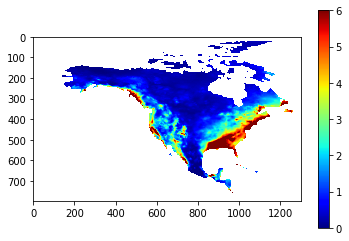

In [103]:
plt.imshow(pcpm,cmap='jet')
plt.colorbar()
plt.clim([0,6])

array([[-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.],
       ...,
       [-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.]], dtype=float32)